In [3]:
import os
import numpy as np
import scipy.ndimage
import skimage.feature
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [416]:
# 1. YUV; ch: 0; gaus_size: 3; gaus_sigma: 2; block_size: 15; C: 1; open_size: 3; min_area: 20; max_area: 400; rect_area: False.
# 10->2. tr=cv2.COLOR_BGR2HSV, ch=2, gaus_size=1, gaus_sigma=1, block_size=15, C=1, open_size=3, min_area=4000, max_area=16000, rect_area=True
# 11->3
# 12->4

In [417]:
def count_obj(bgr_img, tr=cv2.COLOR_BGR2YUV, ch=0, gaus_size=3, gaus_sigma=2, block_size=15, C=1, open_size=3, min_area=20, max_area=400, rect_area=False):
    img = cv2.split(cv2.cvtColor(bgr_img, tr))[ch]
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (gaus_size,gaus_size), gaus_sigma)
    mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
    
    open_kernel = np.ones((open_size,open_size), dtype=np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, open_kernel, iterations=1)
    
    num_labels, labels, stats, centroids  = cv2.connectedComponentsWithStats(opening)
    if rect_area:
        stats_rect_area = stats[:, cv2.CC_STAT_WIDTH] * stats[:, cv2.CC_STAT_HEIGHT]
        kept = (min_area < stats_rect_area) * (stats_rect_area < max_area)
    else: 
        kept = (min_area < stats[:, cv2.CC_STAT_AREA]) * (stats[:, cv2.CC_STAT_AREA] < max_area) 
        
    obj_num = kept.sum()    
    
    for label in range(num_labels):
        if not kept[label]:
            labels[labels==label] = 0
    
    labels[labels!=0] = 1

    return obj_num, opening, labels

4


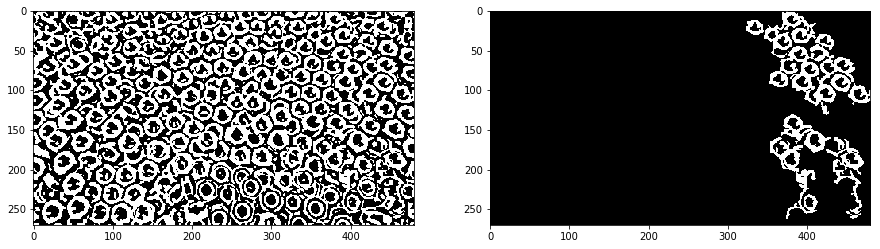

In [423]:
# count, opening, labels = count_obj(bgr_imgs[0])
count, opening, labels = count_obj(bgr_imgs[3], tr=cv2.COLOR_BGR2YUV, ch=0, gaus_size=3, gaus_sigma=1, block_size=15, C=1, open_size=1, min_area=4000, max_area=16000, rect_area=True)
print(count)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(opening, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(labels, cmap='gray')

In [297]:
labels.max()

564

In [229]:
def adaptive(img=img0, blocksize=15, C=5, gaus_size=3, gaus_sigma=2):
    plt.figure(figsize=(15,15)) 
    gray_img = cv2.equalizeHist(img)
    gray_img = cv2.GaussianBlur(gray_img, (gaus_size,gaus_size), gaus_sigma)
    mask=cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, C)
    plt.imshow(mask, cmap='gray')

In [211]:
bgr_imgs = [cv2.imread(f'tasks/count/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('tasks/count/'))]

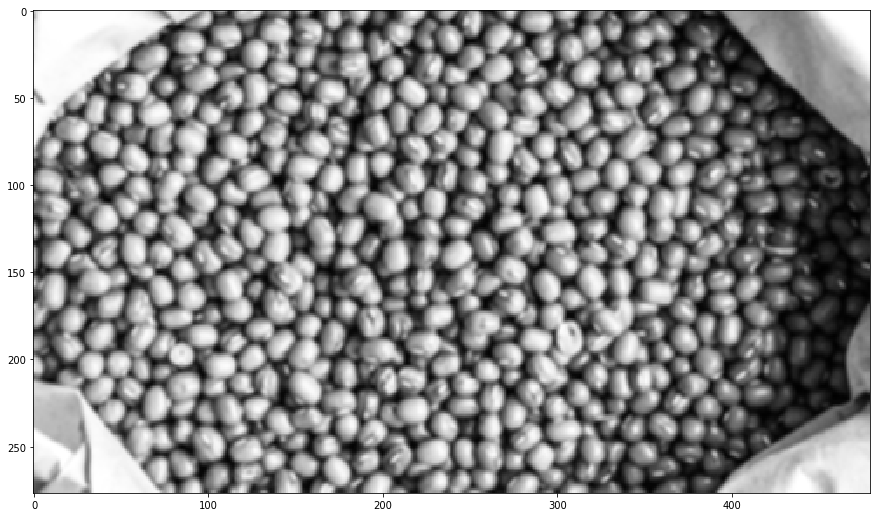

In [274]:
img0, _, _ = cv2.split(cv2.cvtColor(bgr_imgs[0], cv2.COLOR_BGR2YUV))
img0 = cv2.equalizeHist(img0)
img0 = cv2.GaussianBlur(img0, (3,3), 2)
plt.figure(figsize=(15,15))
plt.imshow(img0, cmap='gray')

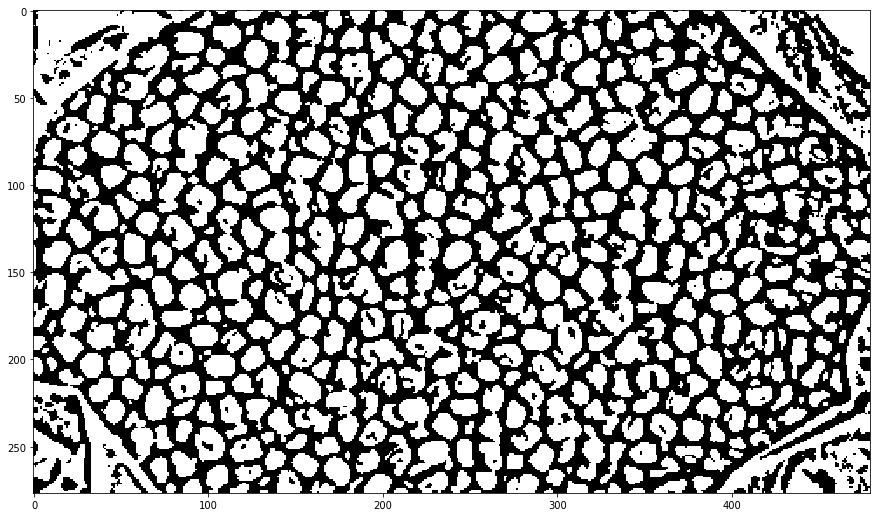

In [248]:
mask0=cv2.adaptiveThreshold(img0, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 1)
plt.figure(figsize=(15,15))
plt.imshow(mask0, cmap='gray')

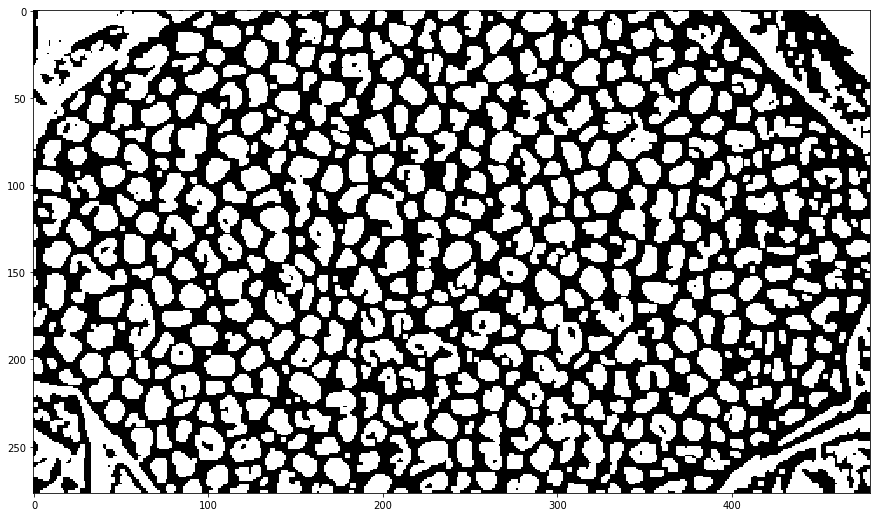

In [258]:
mask_erode0=cv2.morphologyEx(mask0, cv2.MORPH_OPEN,np.ones((3,3), dtype=np.uint8), iterations=1)
plt.figure(figsize=(15,15))
plt.imshow(mask_erode0, cmap='gray')

In [360]:
ada = interactive(adaptive, img, blocksize=(3,23,2), C=(1,20,0.5), gaus_size=(1,31,2), gaus_sigma=(1,10,0.5))
ada

NameError: name 'img' is not defined

In [176]:
def super_pixel(n_segments=10, sigma=1, compactness=10):
    plt.figure(figsize=(20,35))
    for k in range(12):
        img = cv2.cvtColor(bgr_imgs[k], cv2.COLOR_BGR2RGB)
        segments = slic(bgr_imgs[k].astype(np.float32), n_segments=n_segments, sigma=sigma, compactness=compactness)
        plt.subplot(6,2,k+1)
        plt.imshow(mark_boundaries(img, segments))
        
sp = interactive(super_pixel, n_segments=(10,400,10), sigma=(1., 20., 0.1), compactness=(1, 400, 1))
sp

interactive(children=(IntSlider(value=10, description='n_segments', max=400, min=10, step=10), FloatSlider(val…

In [182]:
def super_pixel(n_segments=10, sigma=1, compactness=10):
    seg = []
    for k in range(12):
        img = cv2.cvtColor(bgr_imgs[k], cv2.COLOR_BGR2RGB)
        segments = slic(img.astype(np.float32), n_segments=n_segments, sigma=sigma, compactness=compactness)
        seg.append(segments)
    return seg

def int_sp(j=5, ncomp=400, sigma=2, conn=600):
    seg = super_pixel(ncomp, sigma, conn)
    img_copy = cv2.cvtColor(bgr_imgs[j], cv2.COLOR_BGR2RGB)
    img = img_copy.copy()
    segments = seg[j]
    for s in range(segments.max()+1):
        img[segments == s, :] = (img[segments == s, :].reshape(-1,3)).mean(axis=0)
  
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img_copy)
    plt.subplot(1,2,2)
    plt.imshow(img)

        
sp = interactive(int_sp, j=(0,11,1), ncomp=(2,1600,1), sigma=(1.,50.,1.), conn=(1, 600, 1))
sp

interactive(children=(IntSlider(value=5, description='j', max=11), IntSlider(value=400, description='ncomp', m…

In [371]:
def adaptive(k=0, blocksize=15, C=5, gaus_size=3, gaus_sigma=2):
    plt.figure(figsize=(15,15))
    color_img = bgr_imgs[k]
    gray_img = cv2.split(cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV))[2]
    gray_img - cv2.equalizeHist(gray_img)
    gray_img = cv2.GaussianBlur(gray_img, (gaus_size,gaus_size), gaus_sigma)
    mask=cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, C)
    plt.subplot(2, 1, 1) 
    plt.imshow(color_img[...,::-1])
    plt.subplot(2, 1, 2) 
    plt.imshow(mask, cmap='gray')
        
ada = interactive(adaptive, k=(0, len(imgs)-1, 1), blocksize=(3,23,2), C=(1,20,0.5), gaus_size=(1,31,2), gaus_sigma=(1,10,0.5))
ada

interactive(children=(IntSlider(value=0, description='k', max=11), IntSlider(value=15, description='blocksize'…

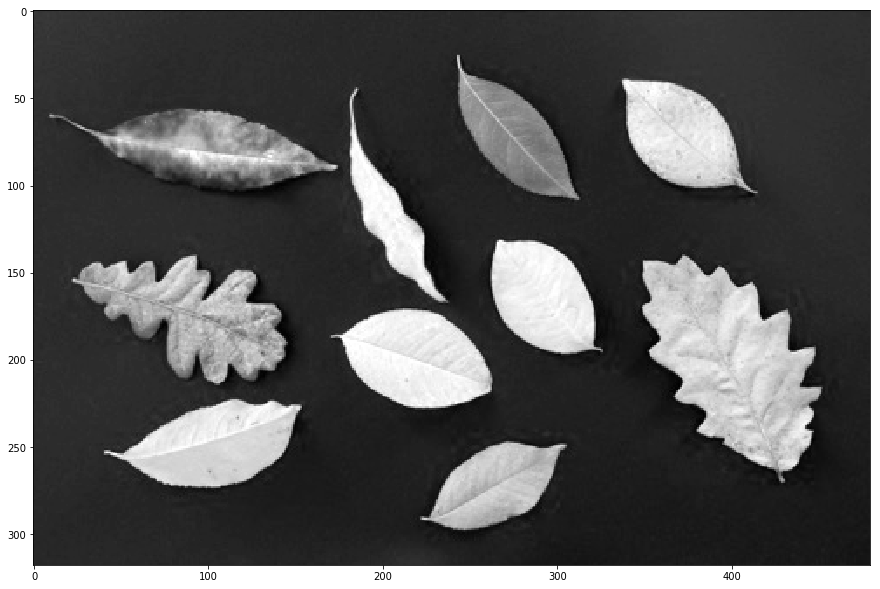

In [366]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(bgr_imgs[1], cv2.COLOR_BGR2HSV)[..., 2], cmap='gray')

In [112]:
imgs = [cv2.imread(f'tasks/count/{name}', cv2.IMREAD_GRAYSCALE) for name in sorted(os.listdir('tasks/count/'))]
blurred_imgs = [cv2.GaussianBlur(img, (5,5), 0) for img in imgs]

th_ad = [cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) for img in imgs]
th_ad_b = [cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2) for img in blurred_imgs]

otsu1 = [cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) for img in imgs]
otsu2 = [cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) for img in blurred_imgs]

In [100]:
color_imgs = [cv2.imread(f'tasks/count/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('tasks/count/'))]
color_imgs = [255-img for img in blurred_imgs]

In [183]:
count_thr_images = [cv2.adaptiveThreshold(count_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5) for count_img in count_imgs]

In [23]:
Ds = [scipy.ndimage.distance_transform_edt(count_thr_image) for count_thr_image in count_thr_images]